In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/titanic


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [230]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import evaluate_genome, get_dataset
from neat.genome import Genome
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [231]:
# auc?

In [5]:
# dir(neat)

In [6]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [7]:
PROJECT = 'neuro-evolution'

### Configuration

In [222]:
DATASET = 'titanic'
ALGORITHM_VERSION = 'bayes-neat'
correlation_ids = ['fix_std2', 'fix_std3', 'free_std']

In [223]:
report_repository = ReportRepository.create(project=PROJECT, logs_path=LOGS_PATH)
executions = {}
chunks = []
for correlation_id in correlation_ids:
    print('###########')
    print(f'CORRELATION ID: {correlation_id}')
    execution_ids = list(report_repository.get_executions(algorithm_version=ALGORITHM_VERSION, dataset=DATASET, correlation_id=correlation_id))
    for execution_id in execution_ids:
        report = report_repository.get_report(algorithm_version=ALGORITHM_VERSION,
                                              dataset=DATASET,
                                              correlation_id=correlation_id,
                                              execution_id=execution_id)
        genome_dict = report.data['best_individual']
        best_individual_fitness = report.data['best_individual_fitness']
        print(f'Fitness of best individual: {best_individual_fitness}')

        genome = Genome.from_dict(genome_dict)
        config = genome.genome_config
        set_configuration(config)
        
        # evaluate genome
        loss = get_loss(problem_type=config.problem_type)
        dataset = get_dataset(config.dataset, train_percentage=config.train_percentage, testing=True)
        
        x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                        dataset=dataset,
                                                        loss=loss,
                                                        problem_type=config.problem_type,
                                                        beta_type=config.beta_type,
                                                        batch_size=config.batch_size,
                                                        n_samples=50,
                                                        is_gpu=config.is_gpu,
                                                        is_testing=True,
                                                        return_all=True)
        multinomial = calculate_multinomial_3(y_pred, n_samples, n_output)
        y_pred = torch.argmax(multinomial, dim=1)

        n_examples = y_true.shape[0] // n_samples
        y_true = y_true[:n_examples]
#         print(f'Loss: {loss_value}')
#         print('Confusion Matrix:')
#         print(confusion_matrix(y_true, y_pred))
#         print(f'Accuracy: {} %')
        accuracy= accuracy_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc(y_true, y_pred)
        chunk = pd.DataFrame({'correlation_id': correlation_id,
                             'execution_id': execution_id,
                             'loss_training': best_individual_fitness,
                             'loss_testing': loss_value,
                             'accuracy': accuracy,
                             'f1': f1,
                             'roc_auc', roc_auc}, index=[0])
        chunks.append(chunk)
    
data = pd.concat(chunks, sort=False)
# path_factory =ReportPathFactory(algorithm_version=ALGORITHM_VERSION, dataset=DATASET, correlation_id=correlation_ids[0])
# path_factory.get_reports_path()

###########
CORRELATION ID: fix_std2
Fitness of best individual: -0.5940015316009521
Training: 428. Testing: 286
Fitness of best individual: -0.5803607702255249
Training: 571. Testing: 143
Fitness of best individual: -0.5826510190963745
Training: 286. Testing: 428
Fitness of best individual: -0.5902540683746338
Training: 571. Testing: 143
Fitness of best individual: -0.5835882425308228
Training: 428. Testing: 286
Fitness of best individual: -0.6227550506591797
Training: 286. Testing: 428
###########
CORRELATION ID: fix_std3
Fitness of best individual: -0.46116772294044495
Training: 571. Testing: 143
Fitness of best individual: -0.4527614414691925
Training: 428. Testing: 286
Fitness of best individual: -0.45599526166915894
Training: 286. Testing: 428
Fitness of best individual: -0.4531386196613312
Training: 428. Testing: 286
Fitness of best individual: -0.44812634587287903
Training: 571. Testing: 143
Fitness of best individual: -0.451641321182251
Training: 286. Testing: 428
###########


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

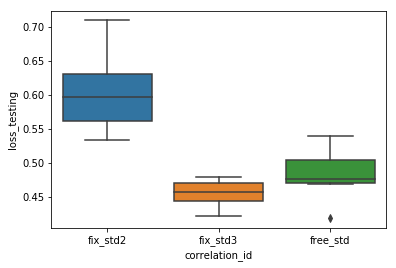

In [224]:
sns.boxplot(data=data, x='correlation_id', y='loss_testing')

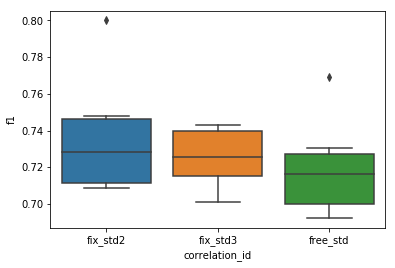

In [225]:
sns.boxplot(data=data, x='correlation_id', y='f1')

In [189]:
n_samples = 50
n_output = 2

x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                dataset=dataset,
                                                loss=loss,
                                                problem_type=config.problem_type,
                                                beta_type=config.beta_type,
                                                batch_size=config.batch_size,
                                                n_samples=n_samples,
                                                is_gpu=config.is_gpu,
                                                is_testing=True,
                                                return_all=True)
# y_pred = torch.argmax(y_pred, dim=1)
# multinomial = convert_to_multinomial(y_pred, n_samples, n_output)
# y_pred = torch.argmax(multinomial, dim=1)

# n_examples = y_true.shape[0] // n_samples
# y_true = y_true[:n_examples]


In [160]:
multinomial

tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [1

In [194]:
a = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
a.shape

torch.Size([286, 50, 2])

In [170]:
sum_ = a.sum(2)
a[:, :, 0] = a[:, :, 0] / sum_
a[:, :, 1] = a[:, :, 1] / sum_

In [193]:
from torch.nn import Sigmoid

In [210]:
def calculate_multinomial_3(y_pred, n_samples, n_output):
    y_pred_permuted = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
    m = Sigmoid()
    multinomial = m(y_pred_permuted)
    sum_ = multinomial.sum(2)
    for output in range(n_output):
        multinomial[:, :, output] = multinomial[:, :, output] / sum_
#     b[:, :, 1] = b[:, :, 1] / sum_
    return multinomial.mean(1)

In [204]:
b.shape

torch.Size([286, 50, 2])

In [192]:
b = a.mean(1)
sum_ = b.sum(1)
b[:, 0] = b[:, 0] / sum_
b[:, 1] = b[:, 1] / sum_
b

tensor([[ 0.1103,  0.8897],
        [ 0.2868,  0.7132],
        [ 0.3174,  0.6826],
        [ 0.2262,  0.7738],
        [ 0.0780,  0.9220],
        [-0.1404,  1.1404],
        [ 0.0826,  0.9174],
        [-0.2693,  1.2693],
        [ 0.3232,  0.6768],
        [ 0.3259,  0.6741],
        [ 0.2707,  0.7293],
        [-0.0182,  1.0182],
        [ 0.4088,  0.5912],
        [-0.1039,  1.1039],
        [ 0.3069,  0.6931],
        [ 0.1944,  0.8056],
        [ 0.5346,  0.4654],
        [-0.4886,  1.4886],
        [ 0.2802,  0.7198],
        [-0.0815,  1.0815],
        [ 0.0783,  0.9217],
        [ 0.4486,  0.5514],
        [-0.3360,  1.3360],
        [-0.2867,  1.2867],
        [ 0.4097,  0.5903],
        [ 0.2651,  0.7349],
        [ 0.0760,  0.9240],
        [ 0.0301,  0.9699],
        [ 0.2193,  0.7807],
        [ 0.2073,  0.7927],
        [-0.2520,  1.2520],
        [ 0.0875,  0.9125],
        [ 0.1792,  0.8208],
        [-0.0824,  1.0824],
        [ 0.2695,  0.7305],
        [-0.0524,  1

In [106]:
def convert_to_multinomial(y_pred, n_samples, n_output):
    class_prediction_per_sample = torch.argmax(y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2), dim=2)
    n_examples = class_prediction_per_sample.shape[0]
    multinomial = torch.zeros(n_examples, n_output)
    
    for output in range(n_output):
        output_count = (class_prediction_per_sample == output).sum(1)
        multinomial[:, output] = output_count / n_samples
    return multinomial


def convert_to_multinomial_2(y_pred, n_samples, n_output):
    logits = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
    sum_ = logits.sum(2)
    for output in range(n_output):
        logits[:, :, output] = a[:, :, output] / sum_
    
    
#     class_prediction_per_sample = torch.argmax(, dim=2)
#     n_examples = class_prediction_per_sample.shape[0]
#     multinomial = torch.zeros(n_examples, n_output)
    
    for output in range(n_output):
        output_count = (class_prediction_per_sample == output).sum(1)
        multinomial[:, output] = output_count / n_samples
    return multinomial

In [107]:
multinomial = convert_to_multinomial(y_pred, n_samples, n_output)

In [115]:
y_pred = torch.argmax(multinomial, dim=1)

In [118]:
n_examples = y_true.shape[0] // n_samples
y_true = y_true[:n_examples]
y_true.shape

torch.Size([428])

In [125]:
accuracy_score(y_true, y_pred) * 100

77.57009345794393

In [78]:
y_pred_permuted = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
y_pred_permuted.shape

torch.Size([428, 10, 2])

In [93]:
(torch.argmax(y_pred_permuted, dim=2) == 0).sum(1).shape

torch.Size([428])

In [67]:
y_pred_2

tensor([[1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        ...,
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0]])

In [46]:
y_pred.shape

torch.Size([4280, 2])

In [58]:
torch.argmax(y_pred.reshape(n_samples, 428,  n_output), dim=2).shape

torch.Size([10, 428])

In [29]:
(y_true[:428] - y_true[428:]

tensor(0)

In [37]:
y_true.reshape(n_samples, 428)

tensor([[1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        ...,
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0]])

In [31]:
y_pred.reshape(428, 2, 2)

tensor([[[ 0.8290,  4.2379],
         [ 1.0596,  1.9037]],

        [[ 0.6045, -1.7164],
         [ 0.3472, -1.2161]],

        [[ 1.5991,  1.6905],
         [ 1.0347, -1.6860]],

        ...,

        [[ 1.2464, -1.2299],
         [ 3.9550,  2.1523]],

        [[ 1.2926, -0.6405],
         [ 1.5285,  4.4967]],

        [[ 1.3371,  0.5004],
         [ 0.9608, -1.7886]]])

In [103]:

# execution_id = '03070516-99e6-40ab-9b69-1764807a3adb'


CORRELATION_ID = 'test'

In [104]:
# execution_id = '2014fc1f-50e0-42b8-800e-69102967c77f' # -0.22
# DATASET = 'mnist_binary'
# ALGORITHM_VERSION = 'bayes-neat'
# CORRELATION_ID = 'test'

In [105]:
report_repository = ReportRepository.create(project='neuro-evolution', logs_path=LOGS_PATH)
report = report_repository.get_report(algorithm_version=ALGORITHM_VERSION,
                                      dataset=DATASET,
                                      correlation_id=CORRELATION_ID,
                                      execution_id=execution_id)

In [106]:
genome_dict = report.data['best_individual']
best_individual_fitness = report.data['best_individual_fitness']
print(f'Fitness of best individual: {best_individual_fitness}')

genome = Genome.from_dict(genome_dict)
config = genome.genome_config
set_configuration(config)

Fitness of best individual: -2.3697526454925537


## Show graph

In [107]:
from neat.plotting.plot_network import plot_genome_network

In [108]:
display(plot_genome_network(genome))

In [109]:
# genome_dict

In [110]:
loss = get_loss(problem_type=config.problem_type)
dataset = get_dataset(config.dataset, testing=True)

In [117]:
x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                    dataset=dataset,
                                                    loss=loss,
                                                    problem_type=config.problem_type,
                                                    beta_type=config.beta_type,
                                                    batch_size=config.batch_size,
                                                    n_samples=1,
                                                    is_gpu=config.is_gpu,
                                                    return_all=True)
print(y_true)
y_pred

tensor([7, 2, 1,  ..., 4, 5, 6])


tensor([[-2.6890, -2.0346,  0.6964,  ..., -0.9401, -0.9440,  0.9615],
        [ 2.5225, -2.8846,  1.5552,  ...,  0.6954,  0.1857, -4.0237],
        [-0.3499,  2.6887, -1.7241,  ...,  3.7133, -0.2113, -2.0000],
        ...,
        [-3.2037,  2.0330, -2.7131,  ...,  1.3300, -0.0857,  1.9407],
        [-0.3025,  2.6943, -1.7036,  ...,  3.7501, -0.2097, -2.0593],
        [ 2.5739, -2.8736,  1.5741,  ...,  0.7363,  0.1865, -4.0924]])

In [123]:
loss_value

2.369753122329712

In [118]:
x.shape

torch.Size([10000, 256])

In [119]:
y_true.shape

torch.Size([10000])

In [120]:
y_pred.shape

torch.Size([10000, 10])

In [122]:
for connection in genome_dict['connection_genes'].values():
#     connection['_weight_std'] = 0.000000001
    value = connection['_weight_std']
    value = connection['_weight_mean']

    print(value)

1.7278531514591198
1.480095555043142
-0.1746260370396398
-1.734405598095528
2.0
1.3677152509761004
0.22731100455084852
-2.0
1.5321293006855448
-0.8476895072309275
-1.1705173870712136
1.8142093890732123
-0.05691644986882578
-1.4904733490144964
-1.31868141699613
-0.18636462772663037
-0.16044850381954287
-1.0883101043361407
-1.4933373890235908
-0.7512856757862271
0.013804253623737328
-1.233543939591855
1.1527165071172938
0.027434074457697744
-0.5271935859197234
-2.0
-0.053561851338297384
-1.931878536003712
1.7875924034843877
-1.5408401292424307
-1.1093673333484333
-0.1259589419472338
-1.363082579560478
1.0084378985916735
0.25163041617326737
-0.25105949446414116
-1.130910856247755
-0.450113934248467
1.9974217433258121
-1.725966302693073
2.0
1.5820946063914012
0.44443812084306666
1.4434844762581167
-2.0
0.5971135566012571
-0.7916792372260617
1.1430336564590768
0.07629138467145702
0.3605110507770068
-1.0485686077371796
0.80506787820727
0.19720481312414484
0.963767473976989
-0.610823225518168

In [53]:
for connection in genome_dict['node_genes'].values():
    value = connection['_bias_std']
#     connection['_bias_std'] = 0.000000001
    print(value)

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001


In [118]:
genome_dict['node_genes']

{'0': {'key': 0,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 0.8057251123197042,
  '_bias_std': 0.001},
 '1': {'key': 1,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '2': {'key': 2,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '3': {'key': 3,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -1.0,
  '_bias_std': 0.001},
 '4': {'key': 4,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.34778403774296407,
  '_bias_std': 0.001},
 '5': {'key': 5,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.3556845272430937,
  '_bias_std': 0.001},
 '6': {'key': 6,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '7': {'key': 7,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.1276673725763255,
  '_bias_std': 0.001},
 '8': {'key': 8,
  'activation': 'tanh',
  'aggregation': 'sum'

In [9]:
config_file = 'mnist_downsampled'
config = create_configuration(filename=f'/{config_file}.json')

In [13]:
# TODO: better mechanism for override
config.pop_size = 20
# config.n_samples = 50
#
config.n_generations = 300
config.node_add_prob = 0.5
config.n_output = 2
config.n_processes = 2


ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'mnist_binary'
# CORRELATION_ID = 'parameters_grid'
CORRELATION_ID = 'solve_binary'

In [14]:
report_repository = ReportRepository.create(project='neuro-evolution', logs_path=LOGS_PATH)
notifier = SlackNotifier.create(channel='batch-jobs')

In [15]:
report = EvolutionReport(report_repository=report_repository,
                         algorithm_version=ALGORITHM_VERSION,
                         dataset=DATASET,
                         correlation_id=CORRELATION_ID)

In [16]:
population_engine = PopulationEngine(stagnation_engine=Stagnation())
speciation_engine = SpeciationEngine()
evaluation_engine = EvaluationStochasticEngine()

GETTING DATASET
GETTING DATASET


In [17]:
evaluation_engine.n_processes

2

### Initialize

In [18]:
end_condition = 'normal'
# try:
# initialize population
population = population_engine.initialize_population()
speciation_engine.speciate(population, generation=0)

population = evaluation_engine.evaluate(population=population)

# report
report.report_new_generation(generation=0,
                                  population=population,
                                  species=speciation_engine.species)

2020-03-19 18:15:03,708 - INFO - Generation 0. Best fitness: -198.308. N-Parameters Best: 8
2020-03-19 18:15:03,709 - INFO -                          Mean fitness: -199.773. Mean N-Parameters: 8.0
2020-03-19 18:15:03,710 - INFO -     New best individual (20) found with fitness -198.308
GETTING DATASET
Confusion Matrix:
[[48435 49565]
 [56598 56902]]
Accuracy: 49.8047281323877 %


In [22]:
def run_generation(generation, population):
    
    # create new generation's population
    population = population_engine.reproduce(species=speciation_engine.species,
                                             pop_size=population_engine.pop_size,
                                             generation=generation)
    # create new species based on new population
    speciation_engine.speciate(population, generation=generation)

    # evaluate
    population = evaluation_engine.evaluate(population=population)

    # generation report
    report.report_new_generation(generation=generation,
                                 population=population,
                                 species=speciation_engine.species)
    generation += 1
    return population

In [23]:
generation = 1

In [27]:
generation += 1
population = run_generation(generation, population)

2020-03-20 09:39:33,083 - INFO - Generation 3. Best fitness: -0.956. N-Parameters Best: 24
2020-03-20 09:39:33,083 - INFO -                          Mean fitness: -21.167. Mean N-Parameters: 22.8


### Check evaluation results

In [31]:
from neat.evaluation.evaluate_simple import evaluate_genome
from neat.evaluation.utils import get_dataset
from neat.loss.vi_loss import get_loss, get_beta

In [29]:
testing = False

In [33]:
dataset = get_dataset(config.dataset, testing=testing)
loss = get_loss(problem_type=config.problem_type)

GETTING DATASET
